## 라이브러리 불러오기

In [1]:
# API 호출
# ## https://data.go.kr/tcs/dss/selectApiDataDetailView.do?publicDataPk=15057440
from urllib.request import Request, urlopen
# Request https://docs.python.org/ko/3/library/urllib.request.html#urllib.request.Request
# urlopen https://docs.python.org/ko/3/library/urllib.request.html#urllib.request.urlopen
from urllib.parse import urlencode, quote_plus
# urlenocde https://docs.python.org/ko/3/library/urllib.parse.html#urllib.parse.urlencode
# quote_plus https://docs.python.org/ko/3/library/urllib.parse.html#urllib.parse.quote_plus
from urllib.parse import unquote
import requests

# 시간 생성
import time
import datetime
from pytz import timezone, utc

# 폴더 자동 생성
import os

# 코드 스케줄링
import threading
# import schedule

# XML 파싱
import xml.etree.ElementTree as ET

# 입력데이터 데이터프레임 작성
import pandas as pd
import numpy as np

# DataFrame 화면 출력                                                # DataFrame 화면 출력 설정이 변경되어 있습니다 #
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None # default = 60

#EXCEL
import openpyxl

# 배차간격 확인 scatter plot 출력
import matplotlib.pyplot as plt

In [2]:
# 폴더 자동 생성 함수
# https://data-make.tistory.com/170
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

## 기본값 설정하기

In [3]:
def todayStr(year:int, month:int, day:int) -> str:
    todayDateTimeStr = f"{year}-{month}-{day}"
    return todayDateTimeStr

## Key Unquote

In [4]:
KEY = 'yEaR%2F3MDedRSlVJL%2F2pxnVg0yre1N5VF3RZ%2FUAt56MJ7J2mNpfqhUvy05pXV0uhHTVY7DbyCR8xmMaDdYga67Q%3D%3D' # 종현
apiKey = unquote(KEY)

## API 호출

In [5]:
"""
노선정보항목조회 busrouteservice/info
routeId의 정류장 목록을 받아옵니다.
"""
def apiInfo(routeId):
    url = 'http://openapi.gbis.go.kr/ws/rest/busrouteservice/station'
    queryParams = '?' + urlencode({ quote_plus('serviceKey') : apiKey, quote_plus('routeId') : routeId })
    request = Request(url + queryParams)
    request.get_method = lambda: 'GET'

    # API를 호출하여 XML 형식으로 된 string 데이터를 변수 "oneLineXML" 에 저장합니다.
    oneLineXML = urlopen(request).read().decode('utf8')
    return oneLineXML

## XML 파싱

In [6]:
def makeInfoDf(routeId:int):
    oneLineXML = apiInfo(routeId)
    # xtree는 "openapi" 도메인 API 호출에서 "headerCd"에 상관없이 3개의 태그를 갖습니다.
    # [comMsgHeader, msgHeader, msgBody]
    xtree = ET.fromstring(oneLineXML)
    # for branch in xtree:
    #     print(branch)
    msgBody = xtree[2]

    tagList = ["stationSeq", "stationId", "stationName", "x", "y"]
    stationList = []
    for branch in msgBody:
        stationList.append([branch.find(tag).text for tag in tagList])

    # station_df의 index가 0부터 시작하는 문제를 해결 하기 위해 rangeIndex를 지정하였습니다.
    stationCount = len(stationList) # 뒤에서 다시 사용되므로 함수로 선언시 주의
    rangeIndex = pd.RangeIndex(start=1, stop=stationCount+1)

    station_df = pd.DataFrame(stationList, columns=tagList, index=rangeIndex)
    station_df = station_df.astype({
        "stationSeq" : "int32",
        "stationId" : "int32", 
        "stationName" : "string",
        "x" : "float",
        "y" : "float"

    })
    return station_df

In [7]:
'''폴더 안에 존재하는 모든(하위 폴더까지 포함) 파일의 경로를 리스트로 반환'''
def allFilePath(routeIdFolder):
    fileList = []
    for root, dirs, files in os.walk(routeIdFolder):
        for fname in files:
            full_fname = os.path.join(root, fname)
            fileList.append(full_fname)
    return fileList

## 데이터 불러오기

In [8]:
'''AWS/Data/daily-time-table폴더에 노선ID(routeId)별로 저장되어 있는 
    텍스트파일(API호출 데이터)의 경로를 존재여부에 상관없이 반환합니다.'''
def getFilePath(routeId, year, month, day):
    curRootDir = os.getcwd()

    subDir = '/AWS/DATA/daily-time-table/'

    strRouteId = str(routeId)
    routeIdFolder = curRootDir + subDir + strRouteId

    fileName = '/' + str(year) + '-' + str(month) + '-' + str(day) + '.txt'

    fileDir = routeIdFolder + fileName
    
    return fileDir

assert getFilePath(204000046, 2020, 12, 23) == '/home/ubuntu/Data-Structure-Project/AWS/DATA/daily-time-table/204000046/2020-12-23.txt'

In [9]:
def rawDf(routeId, year, month, day):
    '''
    routeId 별 정류소 도착시간을 나타내는 2차원 배열을 생성 할 수 있습니다
    마지막 정류소 번호가 필요합니다 : 경유정류소목록조회 API 서비스를 이용하여 가져옵니다.
    중간 또는 처음과 끝에 발생하는 결측치를 채워야 합니다.
    '''
    inputPath = getFilePath(routeId, year, month, day)

    itemTagList = ['DateTime', 'endBus', 'lowPlate', 'plateNo', 'plateType', 'remainSeatCnt', 'routeId', 'stationId', 'stationSeq', 'Nan']
    _raw_df = pd.read_csv(inputPath, sep=' ', skiprows=[0], names=itemTagList)
    _raw_df = _raw_df.drop(["Nan"], axis=1)

    _sorted_df = _raw_df.sort_values(['plateNo'])

    _df = _sorted_df.dropna()

    # string을 datetime객체로 변환하기
    _df['DateTime'] = pd.to_datetime(_df['DateTime'])

    _df = _df.astype({
        'endBus': 'int32', 
        'lowPlate': 'int32', 
        'plateNo': 'string', 
        'plateType': 'int32',
        'remainSeatCnt': 'int32', 
        'routeId': 'int32', 
        'stationId': 'int32', 
        'stationSeq': 'int32'
    })

    return _df

In [10]:
def makePlateNoList(_df):
    # 차량 운행기록을 "plateNo"를 기준으로 구분합니다.
    plateNoList = _df.groupby(['plateNo']).size().index
    return plateNoList

In [11]:
def testPlateNo(plateNo):
    # 차량 번호 한개에 대해서 검사를 실행합니다.
    temp_df =_df[_df['plateNo']==plateNo].sort_values(by='DateTime').reset_index(drop=True)
    tempIndexList = []
    for i in range(1, len(temp_df)):
        if(temp_df.iloc[i-1]['stationSeq'] > temp_df.iloc[i]['stationSeq']):
                tempIndexList.append(i)
                print((temp_df.iloc[i-1]['stationSeq'] , temp_df.iloc[i]['stationSeq']))
                print(i)

        tempIndexList.append(len(temp_df))
    # display(temp_df)
    return temp_df

In [12]:
def initDf(station_df):
    # 정류장의 수 만큼 행을 갖는 빈 데이터프레임을 생성합니다. 
    rangeIndex = station_df.index
    _oneDay_df = pd.DataFrame(index = rangeIndex)
    return _oneDay_df

In [13]:
def makeRangeIndex(station_df):
    return station_df.index

In [14]:
def dropDupDf(routeId:int, year:int, month:int, day:int, diffRate:float):
    _df = rawDf(routeId, year, month, day)
    plateNoList = makePlateNoList(_df)
    station_df = makeInfoDf(routeId)
    _oneDay_df = initDf(station_df)
    
    rangeIndex = makeRangeIndex(station_df)
    # 각 차량 번호를 기준으로 반복문을 수행합니다.
    for plateNo in plateNoList:

        '''특정 차량번호와 같은(_df['plateNo'] == plateNo) 운행기록을 
           DateTime을 기준으로 오름차순으로 정렬(sort_values(['DateTime']합니다.'''
        samebus_df = pd.DataFrame()
        sameBus_df = _df[_df['plateNo'] == plateNo].sort_values(['DateTime']).reset_index(drop=True)

        '''버스는 뒤로가지 않으므로 "stationSeq"가 작아지는 인덱스 i의 리스트를 만듭니다.
           API 호출 오류로 stationSeq가 작아지는 경우가 있습니다. 이 문제를 해결하기 위해 보정계수 diff를 둡니다. 
           diff는 노선의 정류장의 총 개수(rangeIndex.stop)에 일정비율(diffRate)을 곱하여 정의합니다.'''
        indexList = []
        isUsingDiff = True
        diff = rangeIndex.stop * diffRate if ( isUsingDiff ) else 0
        for i in range(1,len(sameBus_df)):
            if(sameBus_df.iloc[i-1]['stationSeq'] > sameBus_df.iloc[i]['stationSeq'] + diff ):
                indexList.append(i)
                #print((sameBus_df.iloc[i-1]['stationSeq'] , sameBus_df.iloc[i]['stationSeq']))

        indexList.append(len(sameBus_df))
        #print(plateNo, indexList)


        # 첫번재 인덱스, 인덱스의 리스트, 마지막 인덱스를 조합하여 호차별로 운행기록을 구분합니다.
        index = 0
        #tupleList = []
        for i in indexList:
            #tupleList.append((index, i))
            small_df = sameBus_df.iloc[index:i].groupby(by=['stationSeq']).min()

            # 정류소 데이터프레임에 합칩니다.
            merge_df = pd.merge(station_df, small_df, how='outer', on='stationId')
            # merge_df = merge_df.set_index(keys='stationSeq')

            _oneDay_df[str(plateNo)+'_'+str(index)] = merge_df['DateTime']
            index=i

    return _oneDay_df

In [15]:
def dropNullCol(_oneDay_df):
    #모든 행이 NULL인 열의 인덱스를 리스트 'nullColList'에 저장합니다.
    nullColList = []
    for colIdx, nullCnt in enumerate(_oneDay_df.isnull().sum(axis=0)):
        stationCnt = station_df.index.stop-1
        if(nullCnt == stationCnt):
            nullColList.append(colIdx)
    # /print nullColList

    nullColumnNameList = []
    for colIndex in nullColList:
        nullColumnNameList.append(_oneDay_df.columns[colIndex])
    # /print nullColumnNameList

    for nullColumnName in nullColumnNameList:
    #     /print nullColumnName
        _oneDay_df.drop(columns=[nullColumnName], inplace=True)
    
    temp_df = _oneDay_df.copy()
    
    return temp_df

In [ ]:
def get_full_data_index(df):
    '''
    함수 [get_full_data_index(df)]은 데이터프레임 안에서 결측치가 하나도 없는 행의 index를 반환합니다.
    시간표를 배차 시간순으로 정렬하기 위해 데이터프레임의 첫번째 행을 기준으로 열(axis=1)을 정렬합니다.
    하지만 데이터프레임의 첫번째 행을 기준으로 정렬을 하게되면 결측치로 인하여 정렬이 안되는 열이 발생합니다.
    결측치가 없는 행을 찾기 위해 제작한 함수 입니다.
    모든 행에 결측치가 존재하면 -1을 반환합니다.
    '''
    for i in df.index:
        nullCountSum = int(df[i-1:i].isnull().sum(axis=1))
        if nullCountSum == 0:
            return i
    #print("모든 행에 결측치가 존재합니다.")    
    return -1

In [17]:
def sortedCol(_oneDay_df):
    # ISSUE* 모든행에 결측치가 존재할때, if(lineIndex == -1), 예외처리가 필요합니다.
    '''
    예외 처리 방법
    DatatFrame.fillna 메소드를 이용하여 결측치를 1회 채운다음
    다시 함수 'get_full_data_index'를 호출한다.
    단, 결측치를 처리한 데이터프레임에선 정렬 기준(columns)만 취한다.
    + 결측치가 없는 두개의 행을 비교하여 순서가 같은지 검정한다. (기능 추가필요)
    '''
    temp_df = _oneDay_df.copy()
    lineIndex = -1
    fillnaCnt = 0
    i = 0
    while(lineIndex < 0):
        i += 1
        lineIndex = get_full_data_index(temp_df)    
        temp_df.fillna(method='bfill', limit=1, inplace = True)

    '''
    결측치가 하나도 없는 행(lineIndex)를 기준으로 데이터프레임의 열(columns)를 정렬한다.
    정렬 후 데이터 프레임의 열의 순서를 변수 'sortedDfColumns' 리스트에 저장한다.
    정렬된 컬럼 리스트로 _oneDay_df를 정렬하고 이를 oneDay_df에 저장한다.
    '''
    sortedDfColumns = temp_df.sort_values(by=lineIndex, axis=1).columns
    print("함수를 {:2d}번 호출하였습니다. 정렬기준: {:2d}".format(i, lineIndex))

    return sortedDfColumns

In [18]:
def makePath(routeId, year, month, day):
    todayDateTimeStr = todayStr(year, month, day)
    outputFileName = todayDateTimeStr + '.csv'
    outputFolderPath = os.getcwd() + '/out/' + str(routeId) + '/r1/'
    createFolder(outputFolderPath)
    outputFilePath = outputFolderPath + outputFileName
    return outputFilePath

### 노선ID(routeId)별 정류소정보 DataFrame

In [19]:
os.getcwd()

'/home/ubuntu/Data-Structure-Project'

In [20]:
routeId = 204000056
year = 2020
month = 12
day = 28

In [21]:
_df = rawDf(routeId, year, month, day)

In [22]:
plateNoList = makePlateNoList(_df)
plateNoList

Index(['경기70사1032', '경기70사1033', '경기70사1034', '경기70사1035', '경기70사1036',
       '경기70아1537', '경기70아1585'],
      dtype='object', name='plateNo')

In [23]:
plateNo = "경기70사1033"
_df[_df['plateNo']==plateNo].sort_values('DateTime')

,DateTime,endBus,lowPlate,plateNo,plateType,remainSeatCnt,routeId,stationId,stationSeq
159,2020-12-28 05:55:33,0,0,경기70사1033,3,41,204000056,201000198,56
162,2020-12-28 05:56:32,0,0,경기70사1033,3,41,204000056,201000198,56
167,2020-12-28 05:57:32,0,0,경기70사1033,3,41,204000056,201000197,57
171,2020-12-28 05:58:32,0,0,경기70사1033,3,41,204000056,201000009,58
174,2020-12-28 05:59:32,0,0,경기70사1033,3,41,204000056,201000009,58
179,2020-12-28 06:00:31,0,0,경기70사1033,3,41,204000056,201000008,59
182,2020-12-28 06:01:31,0,0,경기70사1033,3,41,204000056,201000006,61
184,2020-12-28 06:02:30,0,0,경기70사1033,3,41,204000056,201000006,61
188,2020-12-28 06:03:29,0,0,경기70사1033,3,41,204000056,201000110,62
192,2020-12-28 06:04:29,0,0,경기70사1033,3,41,204000056,202000021,63


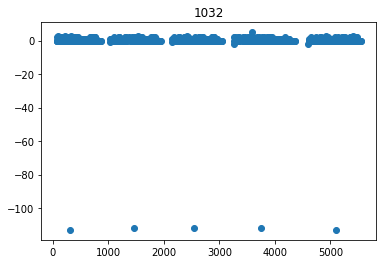

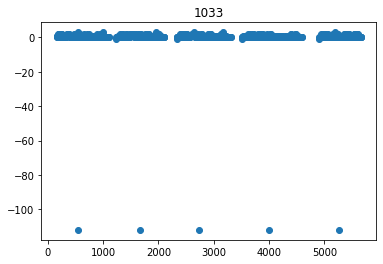

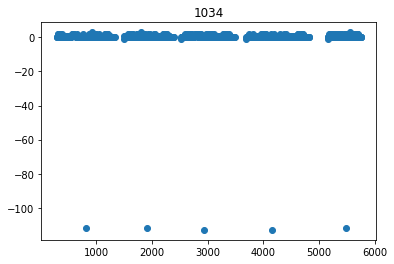

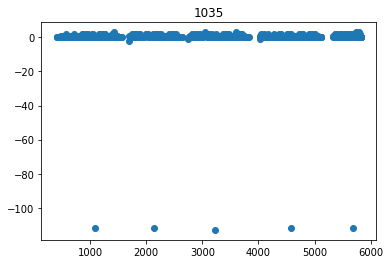

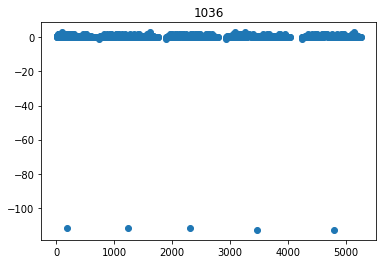

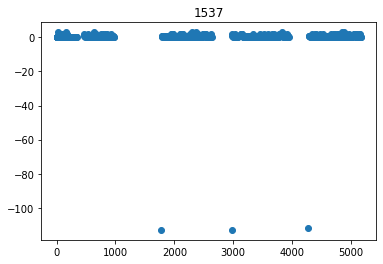

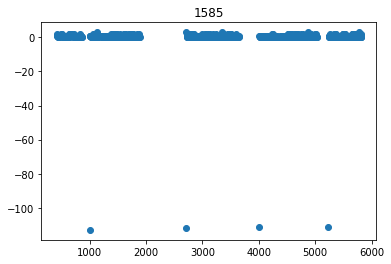

In [24]:
for plateNo in plateNoList:
    test_df = ((_df[_df['plateNo']==plateNo].sort_values('DateTime'))['stationSeq'].diff())
    plt.scatter(test_df.index, test_df)
    plt.title(plateNo[-4:])
    plt.show()

In [25]:
# testPlateNo(plateNo)

### 날짜별 로우데이터(raw-data) DataFrame

In [26]:
"""
_df >>> _dropDup_df >>> _dropNull_df >>> oneDay_df

"""
#station_df
station_df = makeInfoDf(routeId)

In [27]:
#outputPath
outputFilePath = makePath(routeId, year, month, day)

In [28]:
# drop dupolicate data, time table...
_dropDup_df =  dropDupDf(routeId, year, month, day, diffRate=0.95)

In [29]:
_dropDup_df

,경기70사1032_0,경기70사1032_70,경기70사1032_240,경기70사1032_404,경기70사1032_581,경기70사1032_785,경기70사1033_0,경기70사1033_80,경기70사1033_252,경기70사1033_412,경기70사1033_601,경기70사1033_778,경기70사1034_0,경기70사1034_86,경기70사1034_254,경기70사1034_430,경기70사1034_610,경기70사1034_796,경기70사1035_0,경기70사1035_111,경기70사1035_281,경기70사1035_460,경기70사1035_657,경기70사1035_822,경기70사1036_0,경기70사1036_67,경기70사1036_254,경기70사1036_436,경기70사1036_612,경기70사1036_810,경기70아1537_0,경기70아1537_187,경기70아1537_351,경기70아1537_516,경기70아1585_0,경기70아1585_69,경기70아1585_234,경기70아1585_394,경기70아1585_574
1,NaT,2020-12-28 06:37:17,2020-12-28 09:56:35,2020-12-28 13:23:04,2020-12-28 16:53:46,2020-12-28 20:57:14,NaT,2020-12-28 07:17:00,2020-12-28 10:35:16,2020-12-28 13:59:49,2020-12-28 17:40:24,2020-12-28 21:30:03,NaT,2020-12-28 07:58:38,2020-12-28 11:20:01,2020-12-28 14:40:32,2020-12-28 18:14:14,2020-12-28 22:19:48,NaT,2020-12-28 08:48:13,2020-12-28 12:03:41,2020-12-28 15:27:18,2020-12-28 19:23:46,2020-12-28 23:11:29,NaT,2020-12-28 06:04:29,2020-12-28 09:16:55,2020-12-28 12:40:23,2020-12-28 16:04:05,2020-12-28 20:00:34,2020-12-28 05:01:59,2020-12-28 10:57:09,2020-12-28 14:45:30,2020-12-28 18:35:05,NaT,2020-12-28 08:32:18,2020-12-28 13:55:51,NaT,NaT
2,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,NaT,2020-12-28 06:38:17,2020-12-28 09:59:33,2020-12-28 13:25:03,2020-12-28 16:55:46,2020-12-28 21:02:13,NaT,2020-12-28 07:18:00,2020-12-28 10:37:16,2020-12-28 14:06:46,2020-12-28 17:44:22,2020-12-28 21:45:00,NaT,2020-12-28 08:03:36,2020-12-28 11:21:59,2020-12-28 14:44:31,NaT,2020-12-28 22:23:47,NaT,2020-12-28 08:53:10,2020-12-28 12:08:37,2020-12-28 15:29:17,2020-12-28 19:25:46,2020-12-28 23:13:28,NaT,NaT,2020-12-28 09:20:52,2020-12-28 12:42:23,2020-12-28 16:09:03,2020-12-28 20:04:32,2020-12-28 05:03:58,2020-12-28 11:01:07,2020-12-28 14:47:28,2020-12-28 18:38:03,NaT,2020-12-28 08:35:18,2020-12-28 13:56:51,2020-12-28 17:45:22,2020-12-28 21:27:05
4,NaT,NaT,2020-12-28 10:01:33,2020-12-28 13:26:03,2020-12-28 16:57:45,2020-12-28 21:04:12,NaT,2020-12-28 07:18:59,NaT,NaT,NaT,2020-12-28 21:46:00,NaT,NaT,2020-12-28 11:23:58,NaT,2020-12-28 18:19:12,NaT,NaT,2020-12-28 08:55:08,NaT,2020-12-28 15:36:15,2020-12-28 19:30:44,2020-12-28 23:15:28,NaT,2020-12-28 06:07:28,NaT,NaT,2020-12-28 16:11:02,2020-12-28 20:06:31,2020-12-28 05:04:57,2020-12-28 11:02:06,2020-12-28 14:48:28,2020-12-28 18:40:03,NaT,2020-12-28 08:38:16,2020-12-28 13:57:50,2020-12-28 17:52:19,NaT
5,NaT,2020-12-28 06:40:16,2020-12-28 10:02:33,2020-12-28 13:29:02,2020-12-28 16:58:45,2020-12-28 21:05:12,NaT,2020-12-28 07:19:59,2020-12-28 10:39:15,2020-12-28 14:08:46,2020-12-28 17:46:22,2020-12-28 21:47:00,NaT,2020-12-28 08:04:35,2020-12-28 11:24:58,2020-12-28 14:45:30,2020-12-28 18:22:12,2020-12-28 22:24:46,NaT,2020-12-28 08:56:08,2020-12-28 12:09:36,2020-12-28 15:39:14,2020-12-28 19:31:44,2020-12-28 23:16:28,NaT,2020-12-28 06:10:28,2020-12-28 09:22:50,2020-12-28 12:43:22,2020-12-28 16:13:02,2020-12-28 20:07:31,2020-12-28 05:05:57,2020-12-28 11:04:05,2020-12-28 14:50:27,2020-12-28 18:41:03,NaT,2020-12-28 08:40:15,2020-12-28 13:59:49,2020-12-28 17:58:18,2020-12-28 21:31:03
6,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
7,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
8,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
9,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [30]:
# drop whole-Null Column
_dropNull_df = dropNullCol(_dropDup_df)

In [31]:
# sorting DataFrame with sorted DataFrame Columns List which is from fillna-ed DataFrame
sortedDfColumns = sortedCol(_dropNull_df)
oneDay_df = _dropNull_df[sortedDfColumns].copy()

함수를  1번 호출하였습니다. 정렬기준: 94


In [32]:
print(oneDay_df.shape)

(94, 39)


In [33]:
oneDay_df.columns

Index(['경기70아1537_0', '경기70사1036_0', '경기70사1036_67', '경기70사1032_0',
       '경기70사1033_0', '경기70사1032_70', '경기70사1033_80', '경기70사1034_0',
       '경기70아1585_0', '경기70사1034_86', '경기70사1035_0', '경기70아1585_69',
       '경기70사1035_111', '경기70사1036_254', '경기70사1032_240', '경기70사1033_252',
       '경기70아1537_187', '경기70사1034_254', '경기70사1035_281', '경기70사1036_436',
       '경기70사1032_404', '경기70아1585_234', '경기70사1033_412', '경기70사1034_430',
       '경기70아1537_351', '경기70사1035_460', '경기70사1036_612', '경기70사1032_581',
       '경기70사1033_601', '경기70아1585_394', '경기70사1034_610', '경기70아1537_516',
       '경기70사1035_657', '경기70사1036_810', '경기70사1032_785', '경기70아1585_574',
       '경기70사1033_778', '경기70사1034_796', '경기70사1035_822'],
      dtype='object')

In [34]:
#경기77바1893_498
oneDay_df

,경기70아1537_0,경기70사1036_0,경기70사1036_67,경기70사1032_0,경기70사1033_0,경기70사1032_70,경기70사1033_80,경기70사1034_0,경기70아1585_0,경기70사1034_86,경기70사1035_0,경기70아1585_69,경기70사1035_111,경기70사1036_254,경기70사1032_240,경기70사1033_252,경기70아1537_187,경기70사1034_254,경기70사1035_281,경기70사1036_436,경기70사1032_404,경기70아1585_234,경기70사1033_412,경기70사1034_430,경기70아1537_351,경기70사1035_460,경기70사1036_612,경기70사1032_581,경기70사1033_601,경기70아1585_394,경기70사1034_610,경기70아1537_516,경기70사1035_657,경기70사1036_810,경기70사1032_785,경기70아1585_574,경기70사1033_778,경기70사1034_796,경기70사1035_822
1,2020-12-28 05:01:59,NaT,2020-12-28 06:04:29,NaT,NaT,2020-12-28 06:37:17,2020-12-28 07:17:00,NaT,NaT,2020-12-28 07:58:38,NaT,2020-12-28 08:32:18,2020-12-28 08:48:13,2020-12-28 09:16:55,2020-12-28 09:56:35,2020-12-28 10:35:16,2020-12-28 10:57:09,2020-12-28 11:20:01,2020-12-28 12:03:41,2020-12-28 12:40:23,2020-12-28 13:23:04,2020-12-28 13:55:51,2020-12-28 13:59:49,2020-12-28 14:40:32,2020-12-28 14:45:30,2020-12-28 15:27:18,2020-12-28 16:04:05,2020-12-28 16:53:46,2020-12-28 17:40:24,NaT,2020-12-28 18:14:14,2020-12-28 18:35:05,2020-12-28 19:23:46,2020-12-28 20:00:34,2020-12-28 20:57:14,NaT,2020-12-28 21:30:03,2020-12-28 22:19:48,2020-12-28 23:11:29
2,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,2020-12-28 05:03:58,NaT,NaT,NaT,NaT,2020-12-28 06:38:17,2020-12-28 07:18:00,NaT,NaT,2020-12-28 08:03:36,NaT,2020-12-28 08:35:18,2020-12-28 08:53:10,2020-12-28 09:20:52,2020-12-28 09:59:33,2020-12-28 10:37:16,2020-12-28 11:01:07,2020-12-28 11:21:59,2020-12-28 12:08:37,2020-12-28 12:42:23,2020-12-28 13:25:03,2020-12-28 13:56:51,2020-12-28 14:06:46,2020-12-28 14:44:31,2020-12-28 14:47:28,2020-12-28 15:29:17,2020-12-28 16:09:03,2020-12-28 16:55:46,2020-12-28 17:44:22,2020-12-28 17:45:22,NaT,2020-12-28 18:38:03,2020-12-28 19:25:46,2020-12-28 20:04:32,2020-12-28 21:02:13,2020-12-28 21:27:05,2020-12-28 21:45:00,2020-12-28 22:23:47,2020-12-28 23:13:28
4,2020-12-28 05:04:57,NaT,2020-12-28 06:07:28,NaT,NaT,NaT,2020-12-28 07:18:59,NaT,NaT,NaT,NaT,2020-12-28 08:38:16,2020-12-28 08:55:08,NaT,2020-12-28 10:01:33,NaT,2020-12-28 11:02:06,2020-12-28 11:23:58,NaT,NaT,2020-12-28 13:26:03,2020-12-28 13:57:50,NaT,NaT,2020-12-28 14:48:28,2020-12-28 15:36:15,2020-12-28 16:11:02,2020-12-28 16:57:45,NaT,2020-12-28 17:52:19,2020-12-28 18:19:12,2020-12-28 18:40:03,2020-12-28 19:30:44,2020-12-28 20:06:31,2020-12-28 21:04:12,NaT,2020-12-28 21:46:00,NaT,2020-12-28 23:15:28
5,2020-12-28 05:05:57,NaT,2020-12-28 06:10:28,NaT,NaT,2020-12-28 06:40:16,2020-12-28 07:19:59,NaT,NaT,2020-12-28 08:04:35,NaT,2020-12-28 08:40:15,2020-12-28 08:56:08,2020-12-28 09:22:50,2020-12-28 10:02:33,2020-12-28 10:39:15,2020-12-28 11:04:05,2020-12-28 11:24:58,2020-12-28 12:09:36,2020-12-28 12:43:22,2020-12-28 13:29:02,2020-12-28 13:59:49,2020-12-28 14:08:46,2020-12-28 14:45:30,2020-12-28 14:50:27,2020-12-28 15:39:14,2020-12-28 16:13:02,2020-12-28 16:58:45,2020-12-28 17:46:22,2020-12-28 17:58:18,2020-12-28 18:22:12,2020-12-28 18:41:03,2020-12-28 19:31:44,2020-12-28 20:07:31,2020-12-28 21:05:12,2020-12-28 21:31:03,2020-12-28 21:47:00,2020-12-28 22:24:46,2020-12-28 23:16:28
6,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
7,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
8,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
9,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


### 최종 데이터프레임을 csv확장자 파일로 출력

In [35]:
oneDay_df.to_csv(outputFilePath, index=False, date_format='%Y-%m-%d %H:%M:%S')
/print outputFilePath

/home/ubuntu/Data-Structure-Project/out/204000056/r1/2020-12-28.csv


# #######################################################################################

In [36]:
# rangeIndex = makeRangeIndex(station_df)

### csv파일에 저장된 데이터를 datetime 형식으로 변환하여 데이터프레임에 저장

In [37]:
'''
to_datetime Value Error: at least that [year, month, day] must be specified Pandas
https://stackoverflow.com/questions/39992411/to-datetime-value-error-at-least-that-year-month-day-must-be-specified-pand/39992541#39992541
'''
df = pd.read_csv(outputFilePath, parse_dates=True)
/print outputFilePath
df = pd.to_datetime(df.stack(), format='%Y-%m-%d %H:%M%S').unstack()
# df.dtypes

/home/ubuntu/Data-Structure-Project/out/204000056/r1/2020-12-28.csv


ValueError: unconverted data remains: :59

## 앞차와 뒷차의 운행기록을 기준으로 결측치를 채운다.

In [ ]:
'''
01. 데이터프레임의 행 하나(시리즈)를 가져온다.
02. 시리즈의 각 데이터에서 기준시간을 빼서 timedelta 타입으로 변환한다.
    메소드 'interpolate'를 호출하기 위해선 데이터 타입이 'timedelta'여야 한다. 
03. Series.interpolate()를 호출하여 결측치를 채운다.
04. timedelta 타입 데이터를 datetime 타입으로 형 변환한다.
05. 시리즈를 반환한다. 함수 종료.
'''
isShowInfo = True

# 1.
datetimeArr = oneDay_df.iloc[2]

# 2. 시리즈(np.array)에서 기준시간을 뺀다. 데이터 타입이 timedelta로 바뀐다.

sampleTime = np.datetime64(todayDateTimeStr)
timedeltaArr = datetimeArr - sampleTime
timedeltaSeries = pd.Series(timedeltaArr)
totalSecondsSeries = timedeltaSeries.dt.total_seconds()

# *데이터 확인
if (isShowInfo):
    # Count NaT
    beforeNullCnt = timedeltaSeries.isnull().sum()
    print(f"결측치 처리 이전 NaT Cnt:{beforeNullCnt:3d}개")
    
    # Display numpy array dataframe style
    tempDfTDS = pd.DataFrame(datetimeArr).transpose()
    display(tempDfTDS)

# 3. Series.interpolate() 메소드를 호출하여 결측치를 채운다
# newTimedeltaSeries = totalSecondsSeries.interpolate(limit=1)
newTimedeltaSeries = totalSecondsSeries.interpolate(limit_area='inside')
# newTimedeltaSeries = totalSecondsSeries.interpolate(method='values')


# 4. 
newDatetimeSeries = pd.to_datetime(newTimedeltaSeries, unit='s')
newDatetimeSeries = newDatetimeSeries.dt.strftime('%Y-%m-%d %H:%M:%S')

# *데이터 확인
if (isShowInfo):
    # Count NaT
    beforeNullCnt = newTimedeltaSeries.isnull().sum()
    print(f"결측치 처리 이전 NaT Cnt:{beforeNullCnt:3d}개")
    
    # Display numpy array dataframe style
    tempDfTDS = pd.DataFrame(newDatetimeSeries).transpose()
    display(tempDfTDS)

## 배차간격을 확인하고 오류데이터를 NaN으로 변환한다.

In [ ]:
'''
앞차와 뒷차의 배차간격을 저장하는 리스트를 반환한다. 
01. 첫번째 데이터를 예외처리한다. 
    배차간격의 수는 배차수 - 1 이므로 첫번째 데이터를 0으로 하거나 첫차시간을 기록한다.
02. 앞차(prevData) 또는 뒷차(nextData)가 NaT일때 예외처리 한다.
    next
03. 오류데이터(운행 기록 시간이 작아짐)를 예외처리 한다.
'''
prevData = 0
intervalList = []
i = 0

for nextData in newTimedeltaSeries:
    i += 1
    interval = -9999
    if(prevData):
        interval = nextData - prevData
        if(interval<0):
            '''
            오류데이터를 시리즈 데이터에서 NaT로 초기화하는 과정이 필요하다.
            함수로 사용한다면 시리즈 데이터의 값이 바뀔수 있도록 접근해야 한다.
            '''
            newTimedeltaSeries.iloc[i] = float('NaN')
            interval = float('NaN')
            intervalList.append(interval)
            prevData = 0
            continue
        interval /= 60
        intervalList.append(interval)
    else:
        interval = float('NaN')
        intervalList.append(interval)
#     print(f"{i:3d}\tPREV: {prevData:10.0f}\tNEXT: {nextData:10.0f}\tINTERVAL: {interval:7.1f}")
    
    prevData = nextData

intervalList = np.round(intervalList, 0)
print(f"INT LIST의 데이터 수:{len(intervalList):3d}\n", intervalList)

In [ ]:
plt.figure(figsize=(10, 2))
plt.scatter(np.arange(len(intervalList)), intervalList, s=intervalList>0)
plt.show()

### 출차 시간을 그래프에 찍어본다.

In [ ]:
'''
01. 데이터프레임의 행 하나(시리즈)를 가져온다.
02. 시리즈의 각 데이터에서 기준시간, 조사일의 자정(00시)),을 빼서 timedelta 타입으로 변환한다.
'''
isShowInfo = True

# 1.
datetimeArr = oneDay_df.iloc[0]

# 2. 시리즈(np.array)에서 기준시간을 뺀다. 데이터 타입이 timedelta로 바뀐다.
sampleTime = np.datetime64(todayDateTimeStr)
timedeltaArr = datetimeArr - sampleTime
timedeltaSeries = pd.Series(timedeltaArr)
totalSecondsSeries = timedeltaSeries.dt.total_seconds()
totalSecondsSeries /= 60
totalSecondsSeries

plt.figure(figsize=(10, 2))
plt.scatter(np.arange(len(totalSecondsSeries)), totalSecondsSeries, s=totalSecondsSeries>0)
plt.show()

In [ ]:
sampleTime

In [ ]:
'''
01. 데이터프레임의 행 하나(시리즈)를 가져온다.
02. 시리즈의 각 데이터에서 기준시간, 조사일의 자정(00시)),을 빼서 timedelta 타입으로 변환한다.
'''
plt.figure(figsize=(20, 5))

for i in range(1):
    # 1.
    datetimeArr = oneDay_df.iloc[i]

    # 2. 시리즈(np.array)에서 기준시간을 뺀다. 데이터 타입이 timedelta로 바뀐다.
    sampleTime = np.datetime64(todayDateTimeStr)
    timedeltaArr = datetimeArr - sampleTime
    timedeltaSeries = pd.Series(timedeltaArr)
    totalSecondsSeries = timedeltaSeries.dt.total_seconds()
    totalSecondsSeries /= 60
    totalSecondsSeries

    plt.scatter(np.arange(len(totalSecondsSeries)), totalSecondsSeries, s=totalSecondsSeries>0)
plt.show()

In [ ]:
hours = newTimedeltaSeries//3600
minutes = round(newTimedeltaSeries/60 - (hours)*60)
for h, m in zip(hours, minutes):
    try:
        print(int(h), int(m), sep=':')
    except:
        print('nan')

In [ ]:
newDatetimeSeries = pd.to_datetime(newTimedeltaSeries, unit='s')
newDatetimeSeries = newDatetimeSeries.dt.strftime('%Y-%m-%d %H:%M:%S')
pd.DataFrame(newDatetimeSeries).transpose()

### curve-fit을 이용하여 외삽(extrapolation) 실행

In [ ]:
#데이터 확인
datetimeArr = oneDay_df.iloc[1]

# 2. 시리즈(np.array)에서 기준시간을 뺀다. 데이터 타입이 timedelta로 바뀐다.
sampleTime = np.datetime64(todayDateTimeStr)
timedeltaArr = datetimeArr - sampleTime
timedeltaSeries = pd.Series(timedeltaArr)
totalSecondsSeries = timedeltaSeries.dt.total_seconds()
totalSecondsSeries /= 60
pd.DataFrame(totalSecondsSeries).transpose()

# plt.scatter(np.arange(len(totalSecondsSeries)), totalSecondsSeries, s=totalSecondsSeries>0)

In [ ]:
busCount = len(totalSecondsSeries)
newIndex = np.arange(busCount)

In [ ]:
_dropSeries = totalSecondsSeries.reset_index(drop=True).dropna()
_x = _dropSeries.index[:5]
_y = _dropSeries.values[:5]

In [ ]:
# y=ax^2+bx+c를 리턴합니다.
def func(x, a, b, c):
    return a*(x**2) + b*x + c

In [ ]:
popt, pcov = curve_fit(func, _x, _y)

In [ ]:
plt.plot(range(-1, 6), [func(i, *popt) for i in range(-1, 6)])
plt.scatter(range(-1, 6), [func(i, *popt) for i in range(-1, 6)])
plt.scatter(_x, _y)
plt.show()

## 시간별 첫차 시간표를 작성한다.

In [ ]:
"""
시간(hour)을 기준으로 데이터프레임의 열(column)을 세우고 출차 시간(minute)을 기록한 데이터 프레임을 반환한다.
열의 수: 첫차 시간(예: 05시) 부터 막차 시간(예: 23시) 까지 시간(hour)의 수, 예: 23 - 5 + 1, 19열
행의 수: 시간당 최대 배차 수
"""

## datetime을 string으로 형변환한다

In [ ]:
# datetime 객체를 string 객체로 변환합니다. 시간을 가지고 계산해야 하는 일은 이전에 실행하세요.
oneDayString_df = oneDay_df.astype('string')
for column in oneDayString_df.columns:
    oneDayString_df[column] = oneDayString_df[column].str.slice(start=10, stop=16)
# print(oneDayString_df.shape)
    
# [column명 : 차량번호] station_df 와 oneDay_df를 합칩니다. datetime이 아닌 다른 타입의 오브젝트가 행에 붙게 되므로 지금부터는 편집이 어렵습니다.
_finalOneDay_df = pd.concat([station_df,oneDayString_df], axis=1)
_finalOneDay_df.set_index('stationSeq', drop=True, inplace=True)
_finalOneDay_df.shape

In [ ]:
# 정렬된 column에 출차 순서를 배정합니다. (1호차, 2호차, ...)
oneDayString_df.columns = oneDayString_df.columns

In [ ]:
# [column명 : n호차] station_df 와 oneDay_df를 합칩니다. datetime이 아닌 다른 타입의 오브젝트가 행에 붙게 되므로 지금부터는 편집이 어렵습니다.
finalOneDay_df = pd.concat([station_df,oneDayString_df], axis=1)
df = finalOneDay_df.set_index('stationSeq', drop=True)

In [ ]:
html = df.to_html()
# writedata.py
f = open("test.html", 'w')

f.write(html)
f.close()

In [ ]:
for i in range(len(station_df)):
    location = (station_df.iloc[i]['y'], station_df.iloc[i]['x'])
    stationName = station_df.iloc[i]['stationName']
#     print("{content: '<div>", stationName, "</div>',latlng: new kakao.maps.LatLng", location, "},", sep="")

## 일일 시간표 데이터 csv로 내보내기

In [ ]:
rootPath = 'C:/Users/jongh/OneDrive/School/석사/1-2/자료구조/프로젝트/5.DATA/Master/dataAPI/DailyTimeTable/' + str(routeId)
createFolder(rootPath)
outputPath = rootPath + '/' + str(routeId) + '_' + str(year)[-2:] + '-' + str(month) + '-' + str(day) + '.csv'
df.to_csv(outputPath)

# CSV 파일을 읽어서 EXCEL파일로 내보낸다 : 블로그 게시 목적

## 일일 시간표 데이터 csv 읽어오기

In [ ]:
df = pd.read_csv(outputPath)

## 노선번호 받아오기

In [ ]:
KEY = 'yEaR%2F3MDedRSlVJL%2F2pxnVg0yre1N5VF3RZ%2FUAt56MJ7J2mNpfqhUvy05pXV0uhHTVY7DbyCR8xmMaDdYga67Q%3D%3D' # 종현
apiKey = unquote(KEY)

# 노선정보항목조회 busrouteservice/info
# 해당 노선에 대한 노선번호, 기점/종점 정류소, 첫차/막차시간, 배차간격, 운행업체 등의 운행계획 정보를 제공합니다.
url = 'http://openapi.gbis.go.kr/ws/rest/busrouteservice/info'
queryParams = '?' + urlencode({ quote_plus('serviceKey') : apiKey, quote_plus('routeId') : routeId })
# print(url+queryParams)

request = Request(url + queryParams)
request.get_method = lambda: 'GET'
oneLineXML = urlopen(request).read().decode('utf8')
# print(oneLineXML)

xtree = ET.fromstring(oneLineXML)
resultCode = int(xtree[1].find("resultCode").text)
msgBody = xtree[2]

busRouteInfoItem = msgBody[0]
i=0
for info in busRouteInfoItem:
    print(f"{i} {info.tag} : {info.text}")
    i+=1

In [ ]:
routeName = busRouteInfoItem.find("routeName").text

## Excel로 내보내기

In [ ]:
rootPath = 'C:/Users/jongh/OneDrive/School/석사/1-2/자료구조/프로젝트/5.DATA/Master/dataAPI/ExcelExport/'
excelFileName = str(routeName) + '.xlsx'
filePath = rootPath + excelFileName

createFolder(rootPath)
print(filePath)

### 배포용 DataFrame 수정

In [ ]:
export_df = df.set_index('stationName').drop('stationId', axis=1)

### 내보내기

In [ ]:
#-- write an object to an Excel sheet using pd.DataFrame.to_excel()
export_df.to_excel(filePath, # directory and file name to write
            sheet_name = '평일', 
            na_rep = 'NaN', 
            float_format = "%.2f", 
            header = True, 
            #columns = ["group", "value_1", "value_2"], # if header is False
            index = True, 
            index_label = "정류장", 
            startrow = 0, 
            startcol = 0, 
            engine = 'openpyxl', 
            freeze_panes = (1, 1)
            )

## Excel 접근하여 수정하기
https://naakjii.tistory.com/56

In [ ]:
wb = openpyxl.load_workbook(filePath)
sheet = wb['평일']

In [ ]:
sheet.max_column, sheet.max_row

In [ ]:
sheet.column_dimensions['A'].width = 14

In [ ]:
for cell in sheet['A']:
    cell.alignment = openpyxl.styles.Alignment(horizontal='left', vertical='center')
#     cell.fill = openpyxl.styles.fills.PatternFill(patternType='solid', fgColor=openpyxl.styles.colors.Color(rgb='00FF00'))

In [ ]:
wb.save(filePath)

In [ ]:
wb.close()